In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#reading images
hill1 = cv2.imread("C:/Users/Filip/Google Drive/McGillSchool/Semester 7/ECSE 415/Assignments/Assignment2/stitching_images/1Hill.jpg")
hill2 = cv2.imread("C:/Users/Filip/Google Drive/McGillSchool/Semester 7/ECSE 415/Assignments/Assignment2/stitching_images/2Hill.jpg")
hill3 = cv2.imread("C:/Users/Filip/Google Drive/McGillSchool/Semester 7/ECSE 415/Assignments/Assignment2/stitching_images/3Hill.jpg")


**CODING QUESTIONS**

In [25]:
#1) Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.

# convert to RGB
hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# Compute the keypoints/descriptors
keypoints_hill1,descriptors_hill1 = sift.detectAndCompute(hill1,None)
keypoints_hill2,descriptors_hill2 = sift.detectAndCompute(hill2,None)



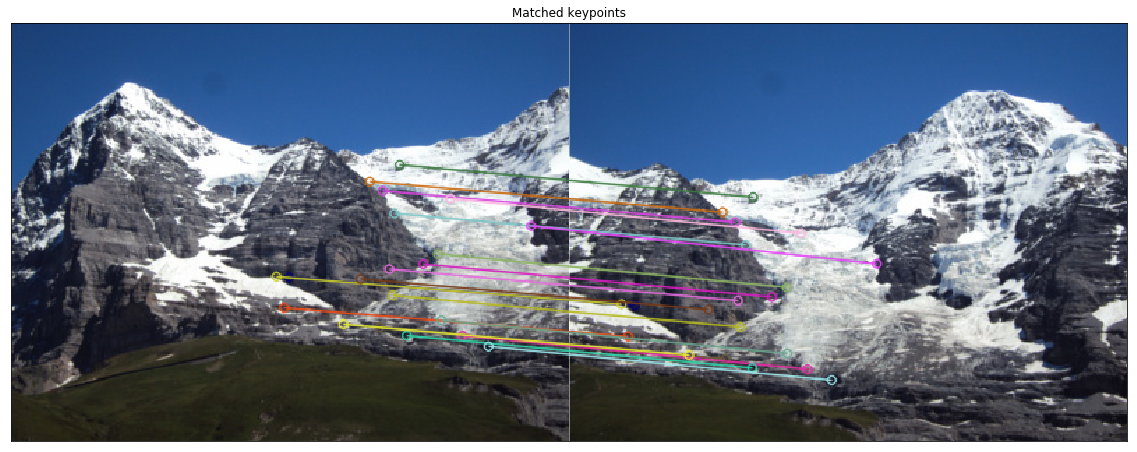

In [26]:
#2) Find matching keypoints in two images and display the 20 best pairs.

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_hill1,descriptors_hill2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
matched_disp = cv2.drawMatches(hill1, keypoints_hill1, hill2, keypoints_hill2, matches[:20],hill1, flags=2)

#display matchings
plt.figure(figsize=(20,20))
plt.imshow(matched_disp), plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

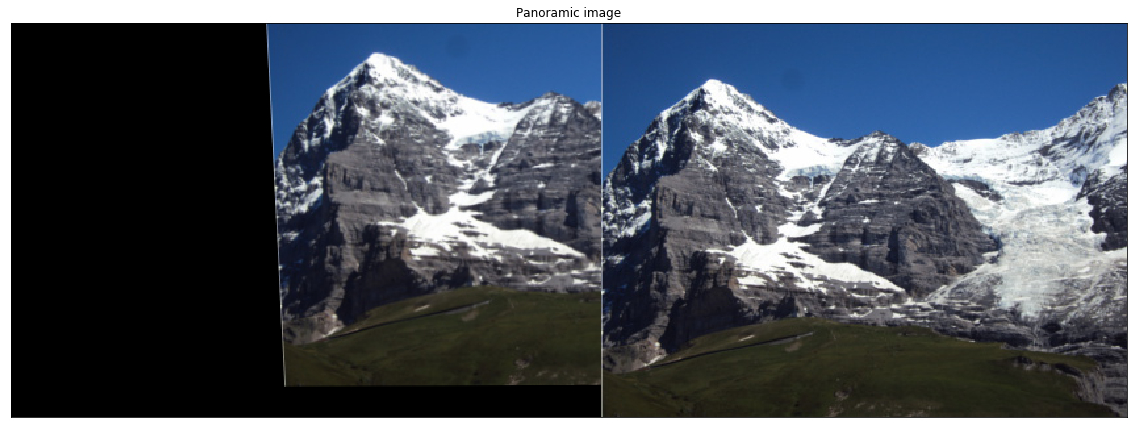

In [35]:
#3) Find homography using RANSAC method and apply transformation to 1Hill. Image 2Hill should not be transformed.

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mp_hill1 = np.float32([keypoints_hill1[i].pt for (__, i) in GoodMatches])
mp_hill2 = np.float32([keypoints_hill2[i].pt for (i, __) in GoodMatches])

# find homography and warp image accordingly
H, __ = cv2.findHomography(mp_hill2, mp_hill1, cv2.RANSAC, 4)

def warpPerspectivePadded(
        src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

wimg = warpPerspectivePadded(hill1, (hill1.shape[0], hill1.shape[1] + hill2.shape[1], 3), H)
wimg[:, -hill1.shape[1]:, :] = hill1

plt.figure(figsize=(20,20))
plt.imshow(wimg), plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
#4) Stitch transformed 1Hill and original 2Hill together using pyramid image blending.

In [11]:
#1) Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.

In [12]:
#2) Find matching keypoints in two images and display the 20 best pairs.

In [13]:
#3) Find homography using RANSAC method and apply transformation to 3Hill. Image 12Hill should not be transformed.

In [14]:
#4) Stitch transformed 3Hill and original 12Hill together using linear image blending.

**REASONING QUESTIONS**

_1. What are the differences betweeen SIFT and SURF? Comment on the speed, number of keypoints and density. Support your argument with statistics._

_2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramyid blending over linear blending?_

_3. What would happen if a random subset of pairs of matching keypoints is used for finding homography?_

_4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography._
